In [ ]:
# It does not require a GPU to run this notebook !!
# This notebook creates the model that we use in the Docker File.

In [7]:
# Please install these versions
# !pip install scikit-learn==0.24.0


In [8]:
import warnings
warnings.filterwarnings('ignore')
import joblib
import pandas as pd
import re
import seaborn as sns
from matplotlib import pyplot as plt
import numpy as np
import nltk
from nltk.corpus import stopwords

nltk.download('wordnet')
nltk.download('punkt')
nltk.download('stopwords')

from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split

from sklearn.pipeline import make_pipeline
from sklearn.metrics import mean_squared_error as mse
from sklearn.linear_model import LinearRegression

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\iamsh\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\iamsh\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\iamsh\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [9]:
%%time

df = pd.read_csv('train.csv')
df = df.fillna('Missing')
df.target = df.target.apply(lambda x: np.floor(x))

# sns.boxplot(x=df.target)
# plt.show()

df.target = df.target.apply(lambda x: -3 if (x==-4) else x)
df.target = df.target.apply(lambda x: 0 if (x==1) else x)

# sns.boxplot(x=df.target)
# plt.show()

df['ex_len'] = df.excerpt.apply(lambda x: len(x))

# sns.histplot(x=df.ex_len)
# plt.show()

# %%time

def cleaner(excerpt):
    clean = nltk.word_tokenize(re.sub("[^a-zA-Z]", " ", excerpt).lower())
    clean = [word for word in clean if not word in set(stopwords.words("english"))]

    lem = nltk.WordNetLemmatizer()
    clean = [lem.lemmatize(word) for word in clean]
    return " ".join(clean)

df.excerpt = df.excerpt.apply(cleaner)


wdf = pd.read_csv('unigram_freq.csv')
wdf['ncol'] = wdf.word.apply(lambda x: True if (x not in set(stopwords.words("english"))) else False)
nwdf = wdf[wdf.ncol==True]

lem1 = nltk.WordNetLemmatizer()
nwdf['lword'] = nwdf.word.apply(lambda x: lem1.lemmatize(str(x)))
nwdf = nwdf.sort_values('count')

def change_scale_word_count(old_value):
    return ( (old_value - 12711) / (1551258643 - 12711) ) * (1 - 0) + 0

nwdf['scaled_count'] = nwdf['count'].apply(change_scale_word_count)
word_freq = dict(zip(nwdf.word, nwdf.scaled_count))

def get_score(excerpt):
    score = 0

    for i in excerpt.split(' '):
        try:
            score += word_freq[i]
        except KeyError:
            pass

    return score

df['excerpt_score'] = df.excerpt.apply(get_score)

Wall time: 5min 14s


In [10]:
%%time

mms1 = MinMaxScaler()
mms2 = MinMaxScaler()

df.target = mms1.fit_transform(np.reshape(list(df.target), (-1,1)))
df.excerpt_score = mms2.fit_transform(np.reshape(list(df.excerpt_score), (-1,1)))

y = df['target']
df.drop(['id', 'url_legal', 'license', 'target', 'standard_error'], axis=1, inplace=True)

name_vectorizer = TfidfVectorizer()
names_encoded = name_vectorizer.fit_transform(df.excerpt)
print(names_encoded.shape)
names_df = pd.DataFrame(data=names_encoded.toarray(), columns=name_vectorizer.get_feature_names())
df = pd.concat([df, names_df], axis=1)
df.drop(['excerpt'], axis=1, inplace=True)
X = df
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

model = LinearRegression()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
mse(y_test, y_pred)

(2834, 22545)
Wall time: 14.8 s


0.05957416566079284

In [11]:
joblib.dump(model, 'CommonLit_Model.pkl')
joblib.dump(name_vectorizer, 'Vectorizer.pkl')
joblib.dump(mms1, 'mms1.pkl')
joblib.dump(mms2, 'mms2.pkl')

['mms2.pkl']

In [5]:
model = joblib.load('CommonLit_Model.pkl')
name_vectorizer = joblib.load('Vectorizer.pkl')
mms1 = joblib.load('mms1.pkl')
mms2 = joblib.load('mms2.pkl')

In [63]:
# %%time

# wdf = pd.read_csv('unigram_freq.csv')
# wdf['ncol'] = wdf.word.apply(lambda x: True if (x not in set(stopwords.words("english"))) else False)
# nwdf = wdf[wdf.ncol==True]

# lem1 = nltk.WordNetLemmatizer()
# nwdf['lword'] = nwdf.word.apply(lambda x: lem1.lemmatize(str(x)))
# nwdf = nwdf.sort_values('count')

# nwdf.to_csv('nwdf.csv', index = False)

Wall time: 2min 30s


### Texts

In [12]:
alice = '''flowers and those cool fountains, but she could
not even get her head though the doorway ;
“ and even if my head would go through,”
thought poor Alice, “ it would be of very little
use without my shoulders. Oh, how I wish I
could shut up like a telescope! I think I could,
if I only knew how to begin.” For, you see, so
many out-of-the-way things had happened lately
that Alice had begun to think that very few
things indeed were really impossible.
There seemed to be no use in waiting by
the little door, so she went back to the table,
half hoping she might find another key on it,
or at any rate a book of rules for shutting
people up like telescopes : this time she found
a little bottle on it, (“which certainly was not
here before,” said Alice,) and tied round the
neck of the bottle was a paper label with the
words “ DRINK ME” beautifully printed on
it in large letters'''
len(alice)

876

In [13]:
fable = '''
On one fine summer's day in a field a Grasshopper was hopping about in a musical mood. An ant passed by bearing along with great toil an ear of corn he was taking to the nest.grasshopper in musical mood

The grasshopper invited the ant to sit for a chat with him. But the ant refused saying that "I’m storing up food for winter". " Why don’t you do the same?" asked the ant to the grasshopper.

ant"Pooh! Why bother about winter?" said the Grasshopper; we have got enough food at present." But the Ant went on its way and continued its toil.

Finally, when winter came, the Grasshopper found itself dying of hunger, while it saw the ants distributing corn and grain from their storage.

Then the Grasshopper understood that…

It is best to prepare for the days of necessity.'''
len(fable)

775

In [14]:
descartes = '''with its seigneurial rights; it seems likely that he set out for Italy at
some point in , and while there visited the shrine of Our Lady
of Loreto, which, according to one early biographer, he had solemnly
undertaken to do immediately after his dreams in  (another
indication, perhaps, if it is true, that he saw the dreams in terms of a
divine directive). By  he was again in Poitou, where he flirted for
the last time with the idea of taking up a legal career; he then travelled on to Paris, to remain there until . This was a tense time in
the capital: the vogue for allegedly lax morality among young gentlemen, connected with the production of libertine (in part obscene)
literary works and publicly expressed indifference (if not worse) to
religion, had led to a number of thunderous denunciations of atheism and free-thinking, and the trial of the prominent poet Théophile
de Viau (–). Descartes makes one brief reference to this
atmosphere and to the free philosophizing associated with it in a
letter to Mersenne dated  May  (AT . ), and quotes once in
a letter of  February  from a poem by Théophile (AT . );
but there is no reason to believe that he ever was beguiled by freethinking, or to doubt the sincerity with which he upholds his own
personal religious belief and his determination to find arguments to
refute deists and atheists.8'''
len(descartes)

1391

In [15]:
physics = '''
The Kelvin scale is part of the SI system of units, so its actual definition is more complicated than the one given above.
First, it is not defined in terms of the freezing and boiling points of water, but in terms of the triple point. The triple point
is the unique combination of temperature and pressure at which ice, liquid water, and water vapor can coexist stably. As
will be discussed in the section on phase changes, the coexistence is achieved by lowering the pressure and consequently
the boiling point to reach the freezing point. The triple-point temperature is defined as 273.16 K. This definition has the
advantage that although the freezing temperature and boiling temperature of water depend on pressure, there is only one
triple-point temperature.
Second, even with two points on the scale defined, different thermometers give somewhat different results for other
temperatures. Therefore, a standard thermometer is required. Metrologists (experts in the science of measurement) have
chosen the constant-volume gas thermometer for this purpose. A vessel of constant volume filled with gas is subjected to
temperature changes, and the measured temperature is proportional to the change in pressure. Using “TP” to represent the
triple point'''
len(physics)

1255

In [16]:
harry_potter = '''He brought the umbrella swishing down through the air to point at
Dudley — there was a flash of violet light, a sound like a firecracker, a sharp
squeal, and the next second, Dudley was dancing on the spot with his hands
clasped over his fat bottom, howling in pain. When he turned his back on them,
Harry saw a curly pig’s tail poking through a hole in his trousers.
Uncle Vernon roared. Pulling Aunt Petunia and Dudley into the other
room, he cast one last terrified look at Hagrid and slammed the door behind
them.
Hagrid looked down at his umbrella and stroked his beard.
“Shouldn’ta lost me temper,” he said ruefully, “but it didn’t work
anyway. Meant ter turn him into a pig, but I suppose he was so much like a pig
anyway there wasn’t much left ter do.”
He cast a sideways look at Harry under his bushy eyebrows.
“Be grateful if yeh didn’t mention that ter anyone at Hogwarts,” he said.
“I’m — er — not supposed ter do magic, strictly speakin’. I was allowed ter do a
bit ter follow yeh an’ get yer letters to yeh an’stuff — one o’ the reasons I was so
keen ter take on the job.”
“Why aren’t you su'''
len(harry_potter)

1105

In [17]:
lord_rings = '''In the dead night, Frodo lay in a dream without light. Then
he saw the young moon rising; under its thin light there
loomed before him a black wall of rock, pierced by a dark
arch like a great gate. It seemed to Frodo that he was lifted
up, and passing over he saw that the rock-wall was a circle
of hills, and that within it was a plain, and in the midst of the
plain stood a pinnacle of stone, like a vast tower but not made
by hands. On its top stood the figure of a man. The moon as
it rose seemed to hang for a moment above his head and
glistened in his white hair as the wind stirred it. Up from the
dark plain below came the crying of fell voices, and the howling of many wolves. Suddenly a shadow, like the shape of
great wings, passed across the moon. The figure lifted his
arms and a light flashed from the staff that he wielded. A
mighty eagle swept down and bore him away. The voices
wailed and the wolves yammered. There was a noise like a
strong wind blowing, and on it was borne the sound of hoofs,
galloping, galloping, galloping from the East. ‘Black Riders!’
thought Frodo as he wakened, with the sound of the hoofs
still echoing in his mind. He wondered if he would ever again
have the courage to leave the safety of these stone walls. He
lay motionless, still listening; but all was now silent, and at
last he turned and fell asleep again or wandered into some
other unremembered dream.'''
len(lord_rings)

1406

In [18]:
moby = '''Entering that gable-ended Spouter-Inn, you found yourself in a wide, low, straggling entry with old-fashioned wainscots, reminding one of the bulwarks of some condemned old craft. On one side hung a very large oilpainting so thoroughly besmoked, and every way defaced, that in the unequal crosslights by which you viewed it, it was only by diligent study and a series of systematic visits to it, and careful inquiry of the neighbors, that you could any way arrive at an understanding of its purpose. Such unaccountable masses of shades and shadows, that at first you almost thought some ambitious young artist, in the time of the New England hags, had endeavored to delineate chaos bewitched. But by dint of much and earnest contemplation, and oft repeated ponderings, and especially by throwing open the little window towards the back of the entry, you at last come to the conclusion that such an idea, however wild, might not be altogether unwarranted.

But what most puzzled and confounded you was a long, limber, portentous, black mass of something hovering in the centre of the picture over three blue, dim, perpendicular lines floating in a nameless yeast. A boggy, soggy, squitchy picture truly, enough to drive a nervous man distracted. Yet was there a sort of indefinite, half-attained, unimaginable sublimity about it that fairly froze you to it, till you involuntarily took an oath with yourself to find out what that marvellous painting meant. Ever and anon a bright, but, alas, deceptive idea would dart you through.—It’s the Black Sea in a midnight gale.—It’s the unnatural combat of the four primal elements.—It’s a blasted heath.—It’s a Hyperborean winter scene.—It’s the breaking-up of the icebound stream of Time. But at last all these fancies yielded to that one portentous something in the picture’s midst. That once found out, and all the rest were plain. But stop; does it not bear a faint resemblance to a gigantic fish? even the great leviathan himself?

In fact, the artist’s design seemed this: a final theory of my own, partly based upon the aggregated opinions of many aged persons with whom I conversed upon the subject. The picture represents a Cape-Horner in a great hurricane; the half-foundered ship weltering there with its three dismantled masts alone visible; and an exasperated whale, purposing to spring clean over the craft, is in the enormous act of impaling himself upon the three mast-heads.'''
len(moby)

2433

In [19]:
cat_700 = '''In February 1848 the people of Paris rose in revolt against the constitutional monarchy of Louis-Philippe. Despite the existence of excellent narrative accounts, the February Days, as this revolt is called, have been largely ignored by social historians of the past two decades. For each of the three other major insurrections in nineteenth-century Paris—July 1830, June 1848, and May 1871—there exists at least a sketch of participants’ backgrounds and an analysis, more or less rigorous, of the reasons for the occurrence of the uprisings. Only in the case of the February Revolution do we lack a useful description of participants that might characterize it in the light of what social history has taught us about the process of revolutionary mobilization.

Two reasons for this relative neglect seem obvious. First, the insurrection of February has been overshadowed by that of June. The February Revolution overthrew a regime, to be sure, but met with so little resistance that it failed to generate any real sense of historical drama. Its successor, on the other hand, appeared to pit key socioeconomic groups in a life-or-death struggle and was widely seen by contemporary observers as marking a historical departure. Through their interpretations, which exert a continuing influence on our understanding of the revolutionary process, the impact of the events of June has been magnified, while, as an unintended consequence,'''
len(cat_700)

1431

In [20]:
cat_500 = '''All available research points to the fact that music education can significantly bolster students' academic skills, particularly when this education is imposed during early childhood. The most notable academic improvement associated with music education, surprisingly, occurs in affected student's performance in mathematics. A recent study, which compared students in school districts all around the world, found that students who began receiving music education in kindergarten scored significantly higher on standardized math tests than did those who began after third grade. Those students who began in third grade, in turn, scored significantly higher than did those who received no music education at all. In fact, correlation studies attempting to link several different factors to higher math test scores have found music education to be the most significant of these factors.'''
len(cat_500)

884

In [21]:
blood_meridian = '''They rode all day upon a pale gastine sparsely grown with saltbush and panicgrass. In
the evening they entrained upon a hollow ground that rang so roundly under the horses'
hooves that they stepped and sidled and rolled their eyes like circus animals and that
night as they lay in that ground each heard, all heard, the dull boom of rock falling
somewhere far below them in the awful darkness inside the world.
On the day that followed they crossed a lake of gypsum so fine the ponies left no track
upon it. The riders wore masks of bone-black smeared about their eyes and some had
blacked the eyes of their horses. The sun reflected off the pan burned the under ides 춖
of their faces and shadow of horse and rider alike were painted upon the fine white
powder in purest indigo. Far out on the desert to the north dustspouts rose wobbling
and augered the earth and some said they'd heard of pilgrims borne aloft like dervishes
in those mindless coils to be dropped broken and bleeding upon the desert again and
there perhaps to watch the thing that had destroyed them lurch onward like some
drunken djinn and resolve itself once more into the elements from which it sprang. Out
of that whirlwind no voice spoke and the pilgrim lying in his broken bones may cry out
and in his anguish he may rage, but rage at what? And if the dried and blackened shell
of him is found among the sands by travelers to come yet who can discover the engine
of his ruin?'''
len(blood_meridian)

1449

In [22]:
finnegans = '''me there and then cease to be? Whatever for, blossoms?) Your
hairmejig if you had one. If I am laughing with you? No,
lovingest, I’m not so dying to take my rise out of you, adored.
Not in the very least. True as God made my Mamaw hiplength
modesty coatmawther! It’s only because the rison is I’m only any
girl, you lovely fellow of my dreams, and because old somebooby
is not a roundabout, my trysting of the tulipies, like that puff
pape bucking Daveran assoiling us behinds. What a nerve!
He thinks that’s what the vesprey’s for. How vain’s that hope in
cleric’s heart Who still pursues th’adult’ rous art, Cocksure that
rusty gown of his Will make fair Sue forget his phiz! Tame
Schwipps. Blessed Marguerite bosses, I hope they threw away
the mould or else we’ll have Ballshossers and Sourdamapplers
with their medical assassiations all over the place. But hold hard
till I’ve got my latchkey vote and I’ll teach him when to wear
what woman callours. On account of the gloss of the gleison
Hasaboobrawbees isabeaubel. And because, you pluckless lankaloot, I hate the very thought of the thought of you and because,
dearling, of course, adorest, I was always meant for an engindear from the French college, to be musband, nomme d’engien,
when we do and contract with encho tencho solver when you
are married to reading and writing which pleasebusiness now
won’t be long for he’s so loopy on me and I’m so leapy like'''
len(finnegans)

1418

### My Pred

Alice 0.1621654658004169
Fable 0.26046353518175236
Descartes 0.46547740192521847
Physics 0.40687244493224584
Harry Potter 0.23714952368034137
Lord of the rings 0.10536357642237837
Blood Meridian 0.22480439038394473
Moby Dick 0.4467370873772478
Finnegans 0.41674786801430763
CAT 700 0.41222533747365286
CAT 500 0.24308914358355072


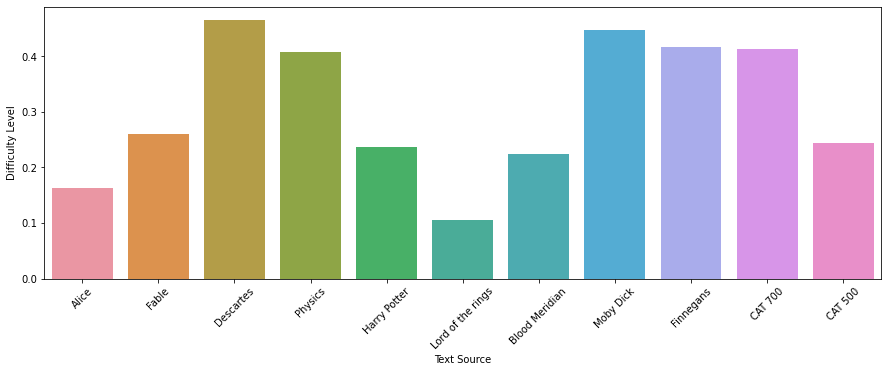

Wall time: 13.7 s
Found existing installation: scikit-learn 0.23.2
Uninstalling scikit-learn-0.23.2:
  Would remove:
    c:\users\iamsh\anaconda3\lib\site-packages\scikit_learn-0.23.2.dist-info\*
    c:\users\iamsh\anaconda3\lib\site-packages\sklearn\*
Proceed (y/n)? 


In [26]:
%%time

import joblib
import pandas as pd
import nltk
from nltk.corpus import stopwords
import re
import warnings
warnings.filterwarnings('ignore')

# nltk.download('wordnet')
# nltk.download('punkt')
# nltk.download('stopwords')

from sklearn.preprocessing import MinMaxScaler
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns

model = joblib.load('CommonLit_Model.pkl')
name_vectorizer = joblib.load('Vectorizer.pkl')

mms1 = joblib.load('mms1.pkl')
mms2 = joblib.load('mms2.pkl')

nwdf = pd.read_csv('nwdf.csv')
def change_scale_word_count(old_value):
    return ( (old_value - 12711) / (1551258643 - 12711) ) * (1 - 0) + 0

nwdf['scaled_count'] = nwdf['count'].apply(change_scale_word_count)
word_freq = dict(zip(nwdf.word, nwdf.scaled_count))

def get_score(excerpt):
    score = 0

    for i in excerpt.split(' '):
        try:
            score += word_freq[i]
        except KeyError:
            pass

    return score

def cleaner(excerpt):
    clean = nltk.word_tokenize(re.sub("[^a-zA-Z]", " ", excerpt).lower())
    clean = [word for word in clean if not word in set(stopwords.words("english"))]

    lem = nltk.WordNetLemmatizer()
    clean = [lem.lemmatize(word) for word in clean]
    return " ".join(clean)

def my_fun(text, length):
    tdf = pd.DataFrame(columns=['excerpt'])
    tdf = tdf.append({'excerpt': text[:length]}, ignore_index=True)
    tdf['ex_len'] = tdf.excerpt.apply(lambda x: len(x))
    tdf.excerpt = tdf.excerpt.apply(cleaner)
    tdf['excerpt_score'] = tdf.excerpt.apply(get_score)
    names_encoded = name_vectorizer.transform(tdf.excerpt)
    names_df = pd.DataFrame(data=names_encoded.toarray(), columns=name_vectorizer.get_feature_names())
    tdf = pd.concat([tdf, names_df], axis=1)
    tdf.drop(['excerpt'], axis=1, inplace=True)
    tdf.excerpt_score = mms2.transform(np.reshape(list(tdf.excerpt_score), (-1,1)))
    ypred = model.predict(tdf)
    return (1-ypred)

texts = [('Alice',alice), ('Fable',fable), ('Descartes', descartes), ('Physics',physics),
        ('Harry Potter', harry_potter), ('Lord of the rings', lord_rings), ('Blood Meridian', blood_meridian),
        ('Moby Dick', moby), ('Finnegans', finnegans),('CAT 700', cat_700), ('CAT 500', cat_500)]

def show_scores(texts): 
    scores = []
    names = []
    length = 600

    for i in texts:
        print(i[0], float(my_fun(i[1], length)))
        scores.append(float(my_fun(i[1], length)))
        names.append(i[0])
        
    plt.figure(figsize=(15,5))
    sns.barplot(x=names, y=scores)
    plt.ylabel('Difficulty Level')
    plt.xlabel('Text Source')
    plt.xticks(rotation=45)
    plt.show()
    
show_scores(texts)